# MATH 387 Lab Assignment 3
### Haruki Moriguchi
### April 13, 2018
---

### Question 1

In [50]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt

In [3]:
# Returns array of n chebyshev nodes in the interval [a, b]
def chebyshev_nodes(a, b, n):
    p = .5*(a + b)
    q = .5*(b - a)
    return np.array([p + q*np.cos(((2*k - 1)*np.pi)/(2*n)) for k in range(1, n + 1)])

In [4]:
# Returns the k-th Lagrange basis polyomial (function)
def lagrange_basis(k, nodes):
    nodes_k = np.delete(nodes, k, 0) # delete k-th node
    def phi(x):
        l = lambda y: np.prod(y - nodes_k) / np.prod(nodes[k] - nodes_k)
        if isinstance(x, (int, long, float, complex)): return l(x)
        else: return np.array([l(y) for y in x]) # accommodation for question 5
    return phi

In [5]:
# Returns the lambda_n function
def lambda_n(nodes):
    return lambda x: np.add.reduce(np.abs([lagrange_basis(k, nodes)(x) for k in range(len(nodes))]))

In [6]:
# Returns the Lebesgue constant for Chebyshev interpolation with degree n
# The interval is [-1, 1], and the maximum is attained at x = 1 for each polynomial.
def chebyshev_lebesgue_const(n):
    return lambda_n(chebyshev_nodes(-1, 1, n + 1))(1)

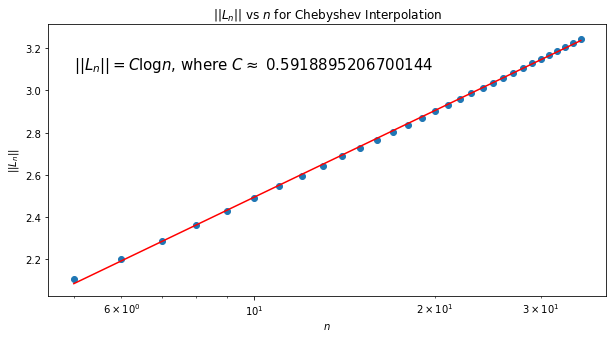

In [7]:
min = 5
max = 35
n_list = np.array(range(min, max + 1))
L = [chebyshev_lebesgue_const(n) for n in n_list]
fit = np.polyfit(np.log(n_list), L, deg=1)
fit_x = np.linspace(min, max, 150)
fit_y = fit[0]*np.log(fit_x) + fit[1]

plt.figure(figsize=(10, 5))
plt.scatter(n_list, L)
plt.plot(fit_x, fit_y, color='red')
plt.xscale('log')
plt.xlabel(r'$n$')
plt.ylabel(r'$||L_n||$')
plt.title(r'$||L_n||$ vs $n$ for Chebyshev Interpolation')
plt.text(5, 3.1, r'$||L_n|| = C \log n$, where $C \approx$ ' + str(fit[0]), fontsize=15)
plt.show()

From the plot, we obtain $||L_n|| = C \log n$, where $C \approx 0.592$.

---

### Question 2

We first compute $\lambda_n'$:
$$
    \lambda_n'(x) = \sum_{k=0}^n \mathrm{sgn}(\phi_{n, k}(x))\phi_{n,k}'(x), \qquad \phi_{n, k}'(x) = \sum_{i = 0, i \ne k}^n \left[ \frac{1}{x_k - x_i} \prod_{j = 0, j\not\in\{i, k\}}^n \frac{x - x_j}{x_k - x_j} \right] = \sum_{i = 0, i \ne k}^n \frac{\phi_{n,k}(x)}{x - x_i} = \phi_{n, k}(x) \sum_{i = 0, i \ne k}^n \frac{1}{x - x_i}
$$

In [8]:
# Returns the derivative of the k-th Lagrange basis polynomial
# We use the last equality in our implementation for efficiency.
def lagr_basis_deriv(k, nodes):
    nodes_k = np.delete(nodes, k, 0)
    return lambda x: lagrange_basis(k, nodes)(x) * np.add.reduce(1./(x - nodes_k))

In [9]:
# Returns a function to calculate the derivative of lambda_n
def lambda_deriv(nodes):
    return lambda x: np.add.reduce(np.array([
        np.sign(lagrange_basis(k, nodes)) * lagr_basis_deriv(k, nodes)(x)
        for k in range(len(nodes))
    ]))

To use the Newton-Raphson method on $\lambda_n'$, we also have to compute $\lambda_n''$:
$$
    \lambda_n'' = \sum_{k=0}^n \mathrm{sgn}(\phi_{n, k}'(x))\phi_{n, k}''(x), \qquad \phi_{n,k}''(x) = \sum_{i = 0, i\ne k}^n \frac{1}{x_k - x_i}\left[ \sum_{j = 0, j \not\in \{i, k\}} \left( \frac{1}{x_k - x_j} \prod_{l = 0, l\not\in\{i,j,k\}}^n \frac{x-x_l}{x_k - x_l} \right) \right]
$$

We can simplify $\phi_{n, k}(x)$ for easier implementation:
$$
    \phi_{n, k}''(x) = \phi_{n, k}(x) \sum_{i = 0, i\ne k}^n \left[\frac 1 {x-x_i} \sum_{j=0, j\not\in\{i, k\}}^n \frac{1}{x - x_j} \right] = \phi_{n, k}(x) \sum_{i = 0, i \ne k}^n \left[ \frac{1}{x - x_i} \left( \sum_{j = 0, j \ne k}^n \frac{1}{x - x_j} \right) - \frac{1}{x - x_i}\right]
$$

In [10]:
# Returns a function to calculate the 2nd derivative of the k-th Lagrange basis polynomial
def lagr_basis_2nd_deriv(k, nodes):
    nodes_k = np.delete(nodes, k, 0)
    def ans(x):
        t = 1./(x - nodes_k)
        return lagrange_basis(k, nodes)(x) * np.add.reduce(t*(np.add.reduce(t) - t))
    return ans

In [11]:
# Returns a function to calculate the 2nd derivate of lambda_n
def lambda_2nd_deriv(nodes):
    return lambda x: np.add.reduce(np.array([
        np.sign(lagr_basis_deriv(k, nodes)(x)) * lagr_basis_2nd_deriv(k, nodes)(x)
        for k in range(len(nodes))
    ]))

In [12]:
# Newton-Raphson for root finding between an interval [a, b]
def newton_raphson(f, f_deriv, a, b):
    epsilon = 0.00001
    x = (b + a)/2 # start at the midpoint of the interval
    while np.abs(f(x)) > epsilon:
        x_prev = x
        x = x - f(x)/f_deriv(x)
        if np.abs(f(x)) > np.abs(f(x_prev)) or x < a or x > b: return None
    return x

In [101]:
# Compute the lebesgue constant for equidistant nodes
# we assume that the maximum occurs on the outer intervals - take the max of both
def equi_lebesgue_const(n):
    nodes = np.linspace(-1, 1, n)
    (f, f_deriv, f_deriv2) = (lambda_n(nodes), lambda_deriv(nodes), lambda_2nd_deriv(nodes))
    (x_0, x_1, x_2, x_3) = (nodes[0], nodes[1], nodes[n-2], nodes[n-1])
    x_max_1 = newton_raphson(f_deriv, f_deriv2, x_0, x_1)
    x_max_2 = newton_raphson(f_deriv, f_deriv2, x_2, x_3)
    if x_max_1 is None: 
        if f(x_0) > f(x_1): x_max_1 = x_0
        else: x_max_1 = x_0
    if x_max_2 is None: 
        if f(x_2) > f(x_3): x_max_2 = x_2
        else: x_max_2 = x_3
    return np.max([f(x_max_1), f(x_max_2)])

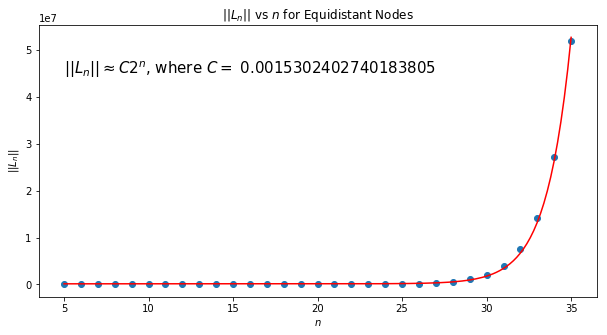

In [14]:
L = [equi_lebesgue_const(n) for n in n_list]
fit = np.polyfit(2**n_list, L, deg=1)
fit_x = np.linspace(min, max, 150)
fit_y = fit[0]*(2**fit_x) + fit[1]

plt.figure(figsize=(10, 5))
plt.scatter(n_list, L)
plt.plot(fit_x, fit_y, color='red')
plt.xlabel(r'$n$')
plt.ylabel(r'$||L_n||$')
plt.title(r'$||L_n||$ vs $n$ for Equidistant Nodes')
plt.text(5, 45000000, r'$||L_n|| \approx C 2^n$, where $C =$ ' + str(fit[0]), fontsize=15)
plt.show()

From the plot, we can see that $||L_n|| \sim 2^n$.

---

### Question 3

For the rest of the lab, we use the composite trapezoidal rule to approximate any intervals.

In [15]:
# Approximates the integral of f using the composite trapezoidal rule
def composite_trapezoidal_appx(f, nodes):
    vals = f(nodes)
    return np.add.reduce(
        (((np.insert(vals, 0, 0) + np.append(vals, 0))/2.) * (np.append(nodes, 0) - np.insert(nodes, 0, 0)))[1:-1]
    )

In [16]:
# Returns the n-th Chebyshev truncation function
def chebyshev_trunc_func(n):
    return lambda t: np.abs(np.sin((n + .5)*t) / (2.*np.sin(.5*t)))

We choose the subintervals of the composite trapezoidal rule to be aligned with the zeroes of the integrand. Furthermore, we put 3 extra nodes between the zeroes so we can get a better approximation, i.e., the boundaries of the intervals are $\theta_k = \frac{k\pi}{4\left(n + \frac 1 2\right)}$.

In [17]:
# Return an array of boundaries for the subintervals between interval [a, b]
def chebyshev_trunc_nodes(n, a, b):
    t = np.pi / (4*(n + .5))
    return np.concatenate((np.array([k*t for k in range(np.int((b - a) / t) + 1)]) + a, [b]))

In [18]:
# Return the approximation of the Lebesgue constant of the Chebyshev truncation
def chebyshev_integral_appx(n):
    return composite_trapezoidal_appx(chebyshev_trunc_func(n), chebyshev_trunc_nodes(n, 0.000001, np.pi))

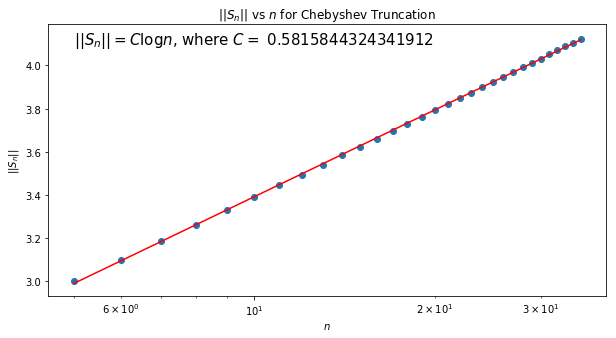

In [19]:
S = [chebyshev_integral_appx(n) for n in n_list]
fit = np.polyfit(np.log(n_list), S, deg=1)
fit_x = np.linspace(min, max, 150)
fit_y = fit[0]*np.log(fit_x) + fit[1]

plt.figure(figsize=(10, 5))
plt.scatter(n_list, S)
plt.plot(fit_x, fit_y, color='red')
plt.xscale('log')
plt.xlabel(r'$n$')
plt.ylabel(r'$||S_n||$')
plt.title(r'$||S_n||$ vs $n$ for Chebyshev Truncation')
plt.text(5, 4.1, r'$||S_n|| = C \log n$, where $C =$ ' + str(fit[0]), fontsize=15)
plt.show()

From the plot, we obtain $||S_n|| = C\log n$, where $C \approx 0.582$.

---

### Question 4

We use the formula
$$
    p_k(x) = \frac 1 {2^k} \sum_{i = 0}^k \binom{k}{i}^2 (x - 1)^{k - i} (x + 1)^k
$$
to compute the $k$-th Legendre polynomial.

In [51]:
# Return the k-th Legendre polynomial
def legendre_polynomial(k):
    return lambda x: (1./(2**k))*np.add.reduce(np.array([
        sp.binom(k, i)**2 * (x - 1)**(k - i) * (x + 1)**i for i in range(k + 1)]))

In [100]:
# Return the integrand
# We calculated a_k = (2k+1)/2 in theory assignment 4
def legendre_trunc_func(n):
    return lambda x: np.abs(np.add.reduce(
        np.array([((2*k + 1.)/2) * legendre_polynomial(k)(x) for k in range(n + 1)])))

In [22]:
# Return the approximate integral of the Lebesgue constant using the composite trapezoidal rule
def legendre_integral_appx(n):
    return composite_trapezoidal_appx(legendre_trunc_func(n), np.linspace(-1, 1, n*15))

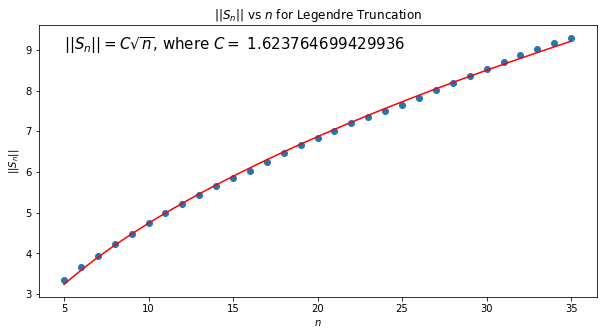

In [23]:
S = [legendre_integral_appx(n) for n in n_list]
fit = np.polyfit(np.sqrt(n_list), S, deg=1)
fit_x = np.linspace(min, max, 150)
fit_y = fit[0]*np.sqrt(fit_x) + fit[1]

plt.figure(figsize=(10, 5))
plt.scatter(n_list, S)
plt.plot(fit_x, fit_y, color='red')
plt.xlabel(r'$n$')
plt.ylabel(r'$||S_n||$')
plt.title(r'$||S_n||$ vs $n$ for Legendre Truncation')
plt.text(5, 9, r'$||S_n|| = C \sqrt{n}$, where $C =$ ' + str(fit[0]), fontsize=15)
plt.show()

From the plot, we find that $||S_n|| = C \sqrt{n}$, where $C \approx 1.624$.

---

### Question 5

In [98]:
# Return the weights for a given set of nodes between the interval [a, b]
def w(k, nodes, a, b):
    return composite_trapezoidal_appx(lagrange_basis(k, nodes), np.linspace(a, b, n*15))

In [99]:
# Return the Lebesgue constant for the Newton Cotes formula for a given degree n
def newton_cotes_Q(n):
    a = 0
    b = 1
    return np.add.reduce(np.abs(np.array([w(k, np.linspace(a, b, n + 1), a, b) for k in range(n + 1)])))

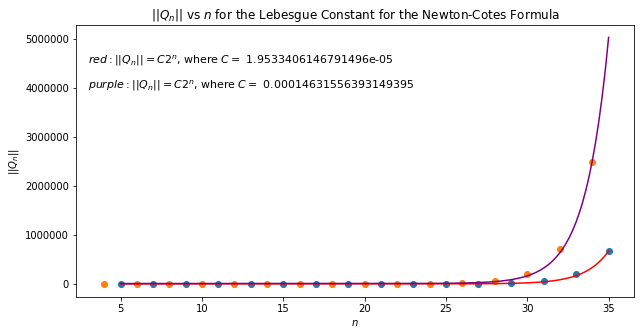

In [102]:
n_odd = np.array(range(min, max+1, 2))
n_even = np.array(range(min-1, max+1, 2))
Q_odd = [newton_cotes_Q(n) for n in n_odd]
Q_even = [newton_cotes_Q(n) for n in n_even]
fit1 = np.polyfit(2**(n_odd), Q_odd, deg=1)
fit_x1 = np.linspace(min, max, 150)
fit_y1 = fit1[0]*(2**fit_x1) + fit1[1] 

fit2 = np.polyfit(2**n_even, Q_even, deg=1)
fit_x2 = np.linspace(min, max, 150)
fit_y2 = fit2[0]*(2**fit_x2) + fit2[1]

plt.figure(figsize=(10, 5))
plt.scatter(n_odd, Q_odd)
plt.scatter(n_even, Q_even)
plt.plot(fit_x1, fit_y1, color='red')
plt.plot(fit_x2, fit_y2, color='purple')
plt.xlabel(r'$n$')
plt.ylabel(r'$||Q_n||$')
plt.title(r'$||Q_n||$ vs $n$ for the Lebesgue Constant for the Newton-Cotes Formula')
plt.text(3, 4500000, r'$red: ||Q_n|| = C 2^n$, where $C =$ ' + str(fit1[0]), fontsize=11)
plt.text(3, 4000000, r'$purple: ||Q_n|| = C 2^n$, where $C =$ ' + str(fit2[0]), fontsize=11)
plt.show()

We observe that $||Q_n||$ increases as $n$ increases, oscillating as it grows exponentially. If we separate the nodes to even and odd points, then $||Q_n|| \approx C2^n$, where $C \approx 0.0000195$ if we take odd nodes and $C \approx 0.000146$ if we take even nodes. If we instead want to consider odd and even nodes together, then a guess on the functional dependence of $||Q_n||$ on $n$ would be
$$
    ||Q_n|| \sim \left(2^{n + 2\sin(2n)}\right)^{1/r}
$$
where $r > 1$. This graph looks like the following for $r = 9$:

<img src="5.png" alt="Drawing" style="width: 400px;"/>